In [1]:
!git clone https://github.com/ml4py/dataset-iiit-pet.git

Cloning into 'dataset-iiit-pet'...
remote: Enumerating objects: 18465, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 18465 (delta 1), reused 3 (delta 1), pack-reused 18460
Receiving objects: 100% (18465/18465), 772.55 MiB | 47.16 MiB/s, done.
Resolving deltas: 100% (3678/3678), done.
Updating files: 100% (18477/18477), done.


In [3]:
import os 
input_dir = "/content/dataset-iiit-pet/images" 
target_dir = "/content/dataset-iiit-pet/annotations/trimaps/"

# get image paths and sort by name (breed) 
input_img_paths = sorted(
    [os.path.join(input_dir, fname)
    for fname in os.listdir (input_dir)
    if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
    for fname in os.listdir (target_dir)
    if fname.endswith(".png") and not fname.startswith(",")])

In [4]:
import os
import pandas as pd

# Define the paths to the dataset files
annotations_path = "/content/dataset-iiit-pet/annotations/list.txt"
labels_path = "/content/dataset-iiit-pet/annotations/trainval.txt"

# Read the breed annotations file
with open(annotations_path, "r") as f:
    breeds = [line.strip() for line in f.readlines()]

# Read the labels file
df_labels = pd.read_csv(labels_path, delim_whitespace=True, header=None, names=["filename", "species", "breed"],)

# Define a function to convert the breed label to cat/dog category label
def get_category_label(species):
    if species == 1:
        return "cat"
    elif species == 2:
        return "dog"
    else:
        return None

# Apply the function to the breed labels to get the category labels
df_labels["category"] = df_labels["species"].apply(get_category_label)

# Save the category labels to a new file
# df_labels[["filename", "category"]].to_csv("/content/dataset-iiit-pet/annotations/trainval_category.txt", sep=" ", index=False, header=False)

In [5]:
df_labels[df_labels.category=='cat']

,filename,species,breed,category
Abyssinian_100,1,1,1,cat
Abyssinian_101,1,1,1,cat
Abyssinian_102,1,1,1,cat
Abyssinian_103,1,1,1,cat
Abyssinian_104,1,1,1,cat
...,...,...,...,...
Sphynx_202,34,1,12,cat
Sphynx_203,34,1,12,cat
Sphynx_204,34,1,12,cat
Sphynx_205,34,1,12,cat


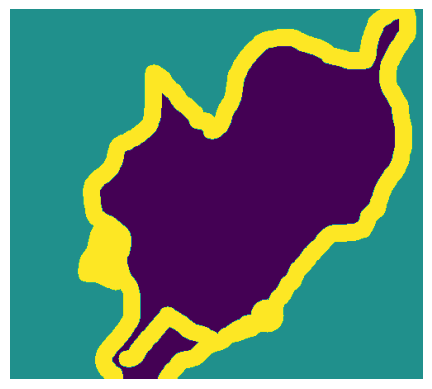

In [6]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
plt.axis("off")
plt.imshow(load_img(input_img_paths [9])) # plot image number 9

def display_target (target_array):
  normalized_array = (target_array.astype("uint8") - 1) * 127 
  plt.axis("off") 
  plt.imshow(normalized_array[:,:,0])
  
img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

In [7]:
import numpy as np

import random

img_size = (200, 200)
num_imgs = int(len(input_img_paths)/3) # total number of images

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
  return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
  img = img_to_array(load_img(path,
                              target_size=img_size,
                              color_mode="grayscale"))
  
  img = img.astype("uint8") - 1  
  return img

In [8]:
input_imgs = np.zeros((num_imgs,) + img_size+ (3,), dtype="float32") 
targets = np.zeros((num_imgs,)+ img_size+ (1,), dtype="uint8") 
for i in range (num_imgs): 
  input_imgs[i] = path_to_input_image(input_img_paths[i])
  targets[i] = path_to_target(target_paths[i])

num_val_samples = 100
train_input_imgs = input_imgs[:-num_val_samples] 
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:] 
val_targets = targets[-num_val_samples:]

In [7]:
import tensorflow
from tensorflow.keras import layers

def get_model(img_size, num_classes):
  inputs = tensorflow.keras.Input(shape=img_size+ (3,)) 
  x = layers.Rescaling (1./255) (inputs)
  x = layers.Conv2D(64, 3, strides = 2, activation="relu", padding="same") (x)
  x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
  x = layers.Conv2D (128, 3, strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D (128, 3, activation="relu", padding="same")(x)  
  x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x) 
  x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)


  x = layers.Conv2DTranspose (256, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x) 
  x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
  x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x) 
  x= layers.Conv2DTranspose( 64, 3, activation="relu", padding="same", strides=2)(x)

  outputs = layers.Conv2D (num_classes, 3, activation="softmax", padding="same")(x)
  model = tensorflow.keras.Model(inputs, outputs)

  return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

Epoch 1/50
37/37 [==============================] - 52s 949ms/step - loss: 0.9752 - val_loss: 0.9301
Epoch 2/50
37/37 [==============================] - 20s 554ms/step - loss: 0.9312 - val_loss: 0.9367
Epoch 3/50
37/37 [==============================] - 21s 566ms/step - loss: 0.9149 - val_loss: 0.9191
Epoch 4/50
37/37 [==============================] - 21s 566ms/step - loss: 0.8948 - val_loss: 0.8626
Epoch 5/50
37/37 [==============================] - 20s 552ms/step - loss: 0.8674 - val_loss: 0.8531
Epoch 6/50
37/37 [==============================] - 20s 552ms/step - loss: 0.8456 - val_loss: 0.8451
Epoch 7/50
37/37 [==============================] - 20s 553ms/step - loss: 0.8522 - val_loss: 0.8466
Epoch 8/50
37/37 [==============================] - 20s 552ms/step - loss: 0.8037 - val_loss: 0.8772
Epoch 9/50
37/37 [==============================] - 20s 551ms/step - loss: 0.8126 - val_loss: 1.1274
Epoch 10/50
37/37 [==============================] - 21s 556ms/step - loss: 0.8045 - val_lo

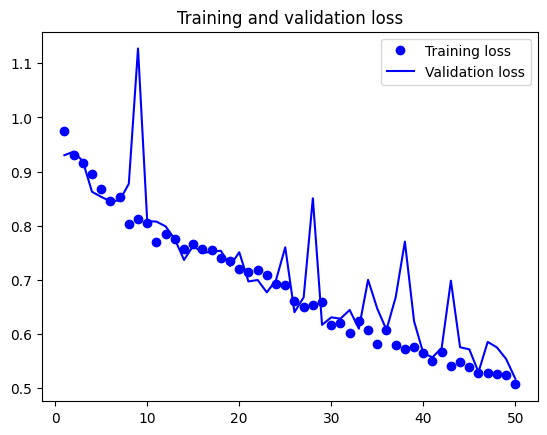

In [8]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
  tensorflow.keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",save_best_only=True)
]
history = model.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks = callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))


epochs = range (1, len(history.history["loss"]) + 1)
loss = history.history["loss"]

val_loss= history.history["val_loss"] 
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

<h2>Inference</h2>

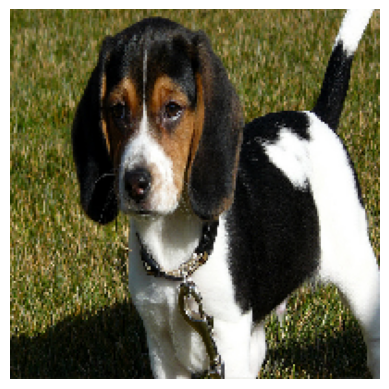

1/1 [==============================] - 1s 776ms/step


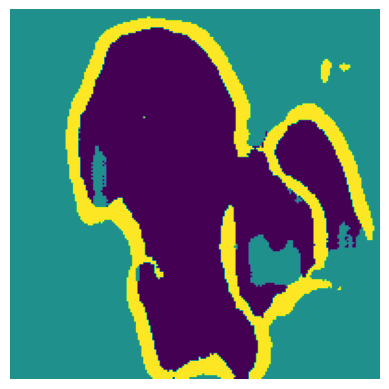

In [9]:
from tensorflow import keras
from tensorflow.keras.utils import array_to_img
model = keras.models.load_model("oxford_segmentation.keras")
i = 4
test_image = val_input_imgs[i]
plt.axis("off") 
plt.imshow(array_to_img(test_image))
plt.show()
# example of how to get the mask for class 0 
mask = model.predict(np.expand_dims(test_image, 0))[0]

# Utility to display a model's prediction 
def display_mask(pred):
  mask= np.argmax(pred, axis=-1) 
  mask *= 127
  plt.axis("off")
  plt.imshow(mask)

display_mask(mask)

In [10]:
!pip install transformers -q
import tensorflow_datasets as tfds
dataset, info = tfds.load('oxford_iiit_pet:3.*.*',with_info=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 96.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.1 MB/s eta 0:00:00


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteZVO67R/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteZVO67R/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


<h2> With skip connections

In [14]:
import tensorflow as tf
from tensorflow.keras import layers

def get_model_with_skip_connections(img_size, num_classes):
    inputs = tf.keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)
    
    # Encoder
    enc1 = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    enc2 = layers.Conv2D(64, 3, activation="relu", padding="same")(enc1)
    enc3 = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(enc2)
    enc4 = layers.Conv2D(128, 3, activation="relu", padding="same")(enc3)
    enc5 = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(enc4)
    enc6 = layers.Conv2D(256, 3, activation="relu", padding="same")(enc5)
    
    # Decoder
    dec1 = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(enc6)
    dec1_skip = layers.concatenate([dec1, enc5])
    
    dec2 = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(dec1_skip)
    dec2_skip = layers.concatenate([dec2, enc4])
    
    dec3 = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(dec2_skip)
    dec3_skip = layers.concatenate([dec3, enc3])
    
    dec4 = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(dec3_skip)
    dec4_skip = layers.concatenate([dec4, enc2])
    
    dec5 = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(dec4_skip)
    dec5_skip = layers.concatenate([dec5, enc1])
    
    dec6 = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(dec5_skip)
    dec6_skip = layers.concatenate([dec6, x])
    
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(dec6_skip)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model


model = get_model_with_skip_connections(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 200, 200, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 100, 100, 64  1792        ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

Epoch 1/30
37/37 [==============================] - 53s 1s/step - loss: 0.9221 - val_loss: 0.9028
Epoch 2/30
37/37 [==============================] - 28s 767ms/step - loss: 0.9034 - val_loss: 0.8807
Epoch 3/30
37/37 [==============================] - 28s 765ms/step - loss: 0.8874 - val_loss: 0.8903
Epoch 4/30
37/37 [==============================] - 28s 768ms/step - loss: 0.8684 - val_loss: 1.1001
Epoch 5/30
37/37 [==============================] - 28s 758ms/step - loss: 0.8597 - val_loss: 0.8465
Epoch 6/30
37/37 [==============================] - 28s 757ms/step - loss: 0.8235 - val_loss: 0.7923
Epoch 7/30
37/37 [==============================] - 28s 761ms/step - loss: 0.8338 - val_loss: 0.8040
Epoch 8/30
37/37 [==============================] - 28s 759ms/step - loss: 0.7942 - val_loss: 0.7710
Epoch 9/30
37/37 [==============================] - 28s 755ms/step - loss: 0.7707 - val_loss: 0.8480
Epoch 10/30
37/37 [==============================] - 28s 761ms/step - loss: 0.7538 - val_loss:

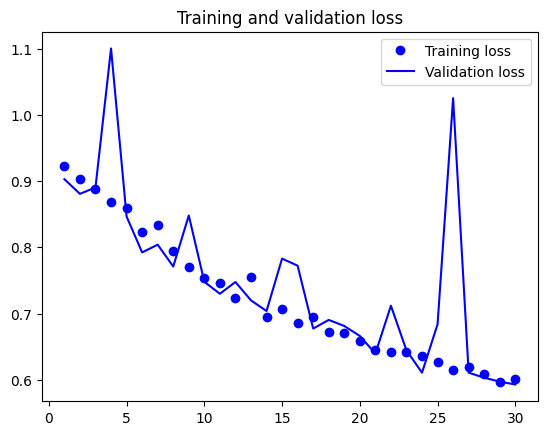

In [18]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
  tf.keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",save_best_only=True)
]
history = model.fit(train_input_imgs, train_targets,
                    epochs=30,
                    callbacks = callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))


epochs = range (1, len(history.history["loss"]) + 1)
loss = history.history["loss"]

val_loss= history.history["val_loss"] 
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

<h2>Inference

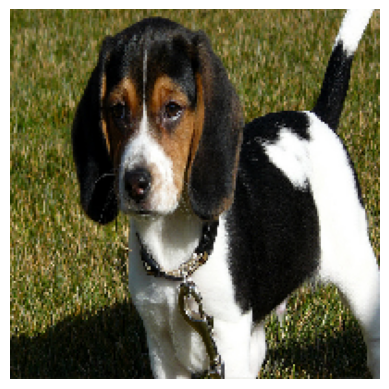

1/1 [==============================] - 1s 877ms/step


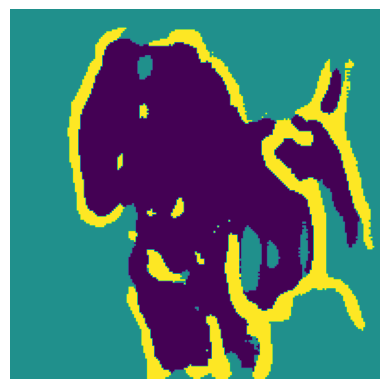

In [19]:
from tensorflow import keras
from tensorflow.keras.utils import array_to_img
model = keras.models.load_model("oxford_segmentation.keras")
i = 4
test_image = val_input_imgs[i]
plt.axis("off") 
plt.imshow(array_to_img(test_image))
plt.show()
# example of how to get the mask for class 0 
mask = model.predict(np.expand_dims(test_image, 0))[0]

# Utility to display a model's prediction 
def display_mask(pred):
  mask= np.argmax(pred, axis=-1) 
  mask *= 127
  plt.axis("off")
  plt.imshow(mask)

display_mask(mask)

<h2>Image Segmentation with SegFormer</h2>

In [11]:
import tensorflow as tf
from tensorflow.keras import backend

image_size=512
mean = tf.constant([0.485, 0.456, 0.406])
std= tf.constant([0.229, 0.224, 0.225])

def normalize(input_image, input_mask):
  input_image = tf.image.convert_image_dtype(input_image, tf.float32)
  input_image = (input_image - mean) / tf.maximum (std, backend.epsilon())
  input_mask -= 1
  return input_image, input_mask

In [12]:
def load_image(datapoint): 
  input_image= tf.image.resize(datapoint["image"], (image_size, image_size))
  input_mask= tf.image.resize(
      datapoint["segmentation_mask"],
      (image_size, image_size),
      method="bilinear",
  )

  input_image, input_mask = normalize(input_image, input_mask)
  input_image = tf.transpose(input_image, (2, 0, 1)) 
  return {"pixel_values": input_image, "labels": tf.squeeze(input_mask)}

auto =  tf.data.AUTOTUNE 
batch_size=4

train_ds = (
    dataset["train"].cache().shuffle(batch_size * 18).map(load_image, num_parallel_calls = auto).batch(batch_size).prefetch(auto)
)
test_ds = (
  dataset["test"].map(load_image, num_parallel_calls = auto).batch(batch_size).prefetch(auto)
)

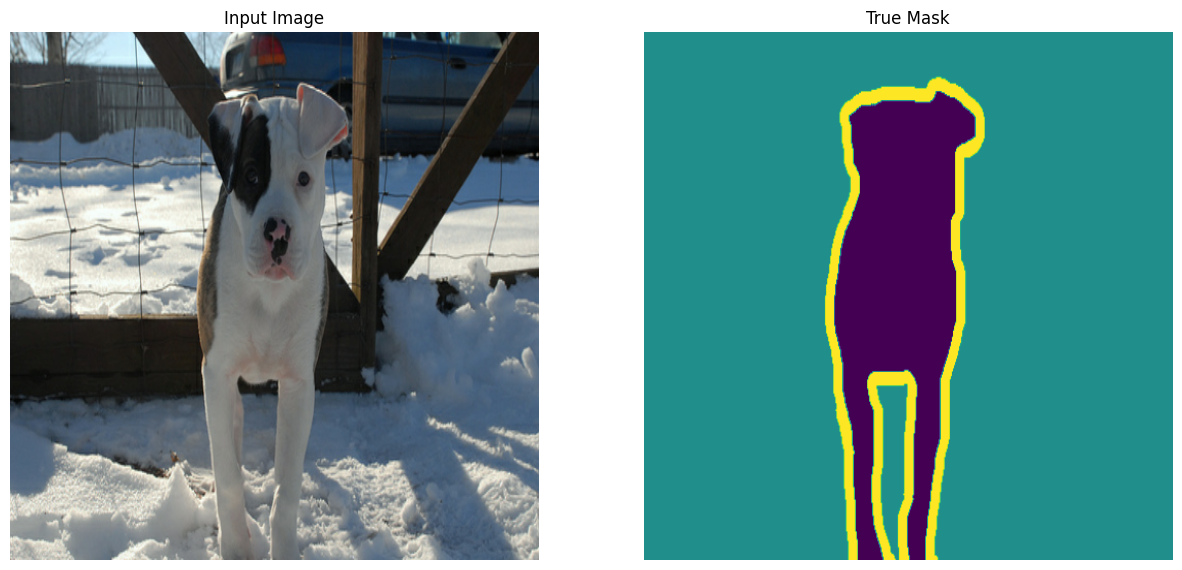

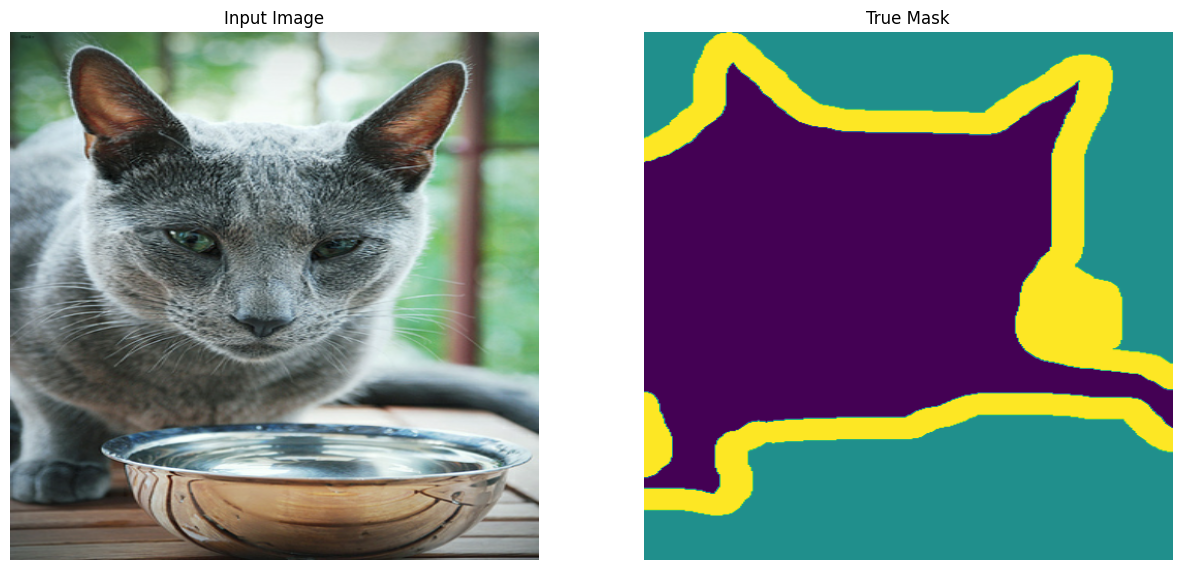

In [19]:
import matplotlib.pyplot as plt

def display(display_list):
   plt.figure(figsize=(15, 15))
   title= ["Input Image", "True Mask", "Predicted Mask"]

   for i in range(len(display_list)):
     plt.subplot(1, len(display_list), i+1)
     plt.title(title[i])
     plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
     plt.axis("off")
   plt.show()

for samples in train_ds.take(2):
  sample_image, sample_mask = samples["pixel_values"][0], samples["labels"][0]
  sample_image= tf.transpose(sample_image, (1, 2, 0))
  sample_mask= tf.expand_dims (sample_mask, -1)
  display([sample_image,sample_mask])

In [30]:
from transformers import TFSegformerForSemanticSegmentation

model_checkpoint = "nvidia/mit-b0"
id2label = {0: "outer", 1: "inner", 2:"border"}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)
model = TFSegformerForSemanticSegmentation.from_pretrained(
     model_checkpoint,
     num_labels = num_labels,
     id2label = id2label,
     label2id = label2id,
     ignore_mismatched_sizes=True,
)

Some layers from the model checkpoint at nvidia/mit-b0 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
lr = 0.0006
optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
model.compile(optimizer = optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [34]:
from IPython.display import clear_output

def create_mask(pred_mask):
  pred_mask= tf.math.argmax(pred_mask, axis=1)
  pred_mask = tf.expand_dims(pred_mask, -1)
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for sample in dataset.take(num):
      images, masks =  sample["pixel_values"], sample["labels"]
      masks = tf.expand_dims(masks, -1)
      pred_masks = model.predict(images).logits
      images = tf.transpose(images, (0, 2, 3, 1))
      display([images[0], masks[0], create_mask(pred_masks)])

  else:
    display(
        [
          sample_image,
          sample_mask,
          create_mask(model.predict(tf.expand_dims(sample_image,0))),
        ]
    )

In [35]:
class DisplayCallback(tf.keras.callbacks.Callback) : 
  def __init__(self,dataset,**kwargs) : 
    super().__init__(**kwargs)
    self.dataset = dataset

def on_epoch_end(self,epoch,logs=None) : 
  clear_output(wait=True)
  show_predictions(self.dataset)
  print('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [36]:
epochs = 5
history = model.fit(
    train_ds,
    validation_data = test_ds,
    callbacks=[DisplayCallback(test_ds)],
    epochs = epochs,
)

Epoch 1/5
920/920 [==============================] - 442s 398ms/step - loss: 0.4008 - val_loss: 0.3905
Epoch 2/5
920/920 [==============================] - 352s 383ms/step - loss: 0.3125 - val_loss: 0.3024
Epoch 3/5
920/920 [==============================] - 340s 369ms/step - loss: 0.2737 - val_loss: 0.3144
Epoch 4/5
920/920 [==============================] - 333s 362ms/step - loss: 0.2704 - val_loss: 0.2688
Epoch 5/5
920/920 [==============================] - 333s 362ms/step - loss: 0.2560 - val_loss: 0.2523


1/1 [==============================] - 4s 4s/step


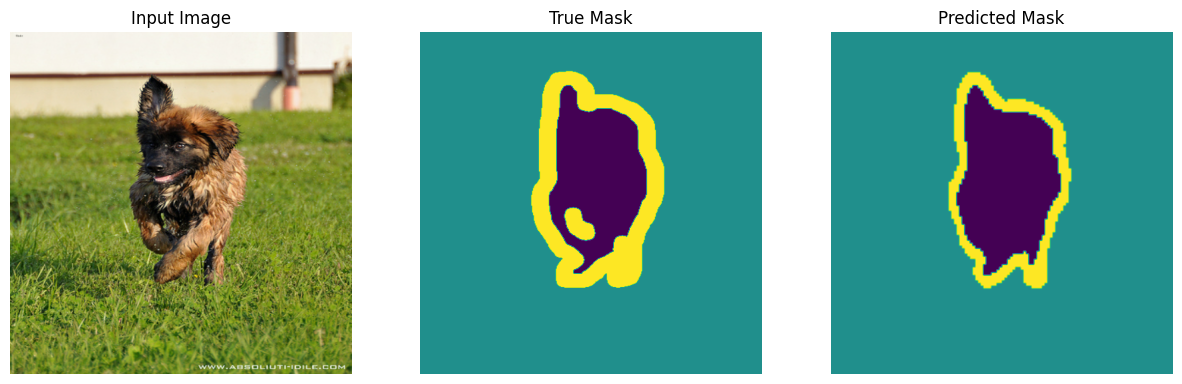

1/1 [==============================] - 0s 139ms/step


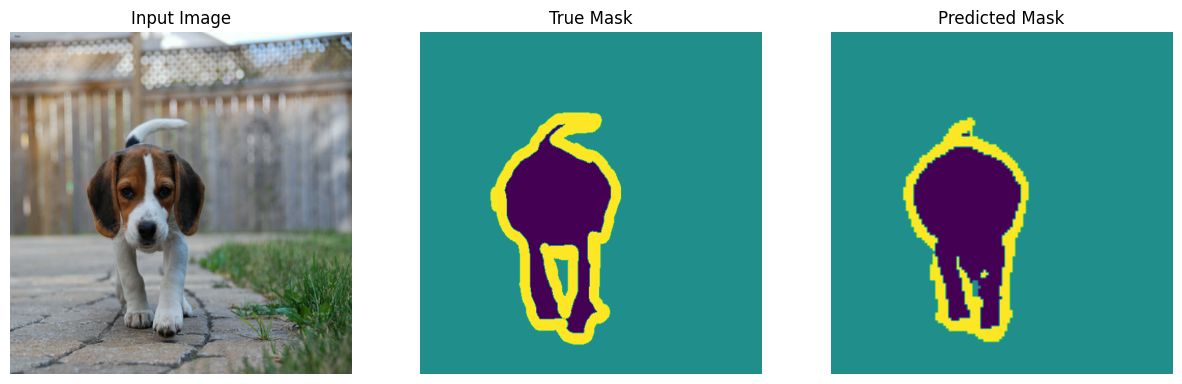

1/1 [==============================] - 0s 127ms/step


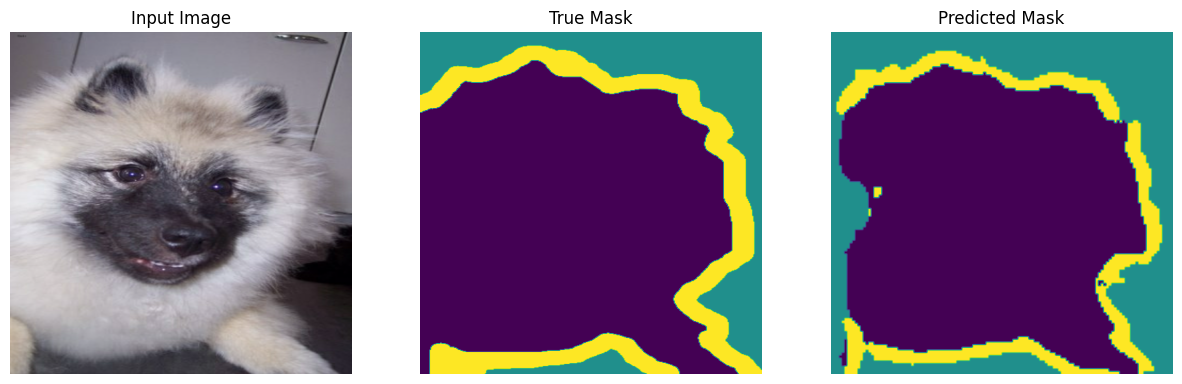

1/1 [==============================] - 0s 103ms/step


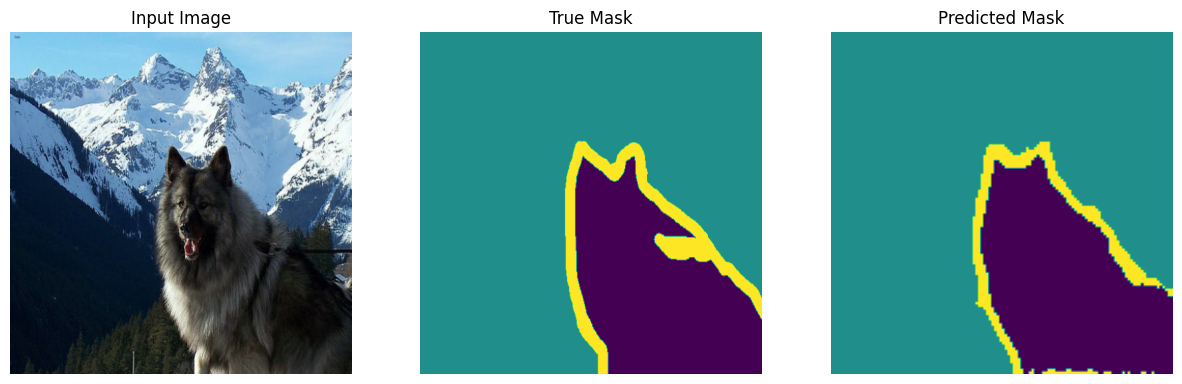

1/1 [==============================] - 0s 109ms/step


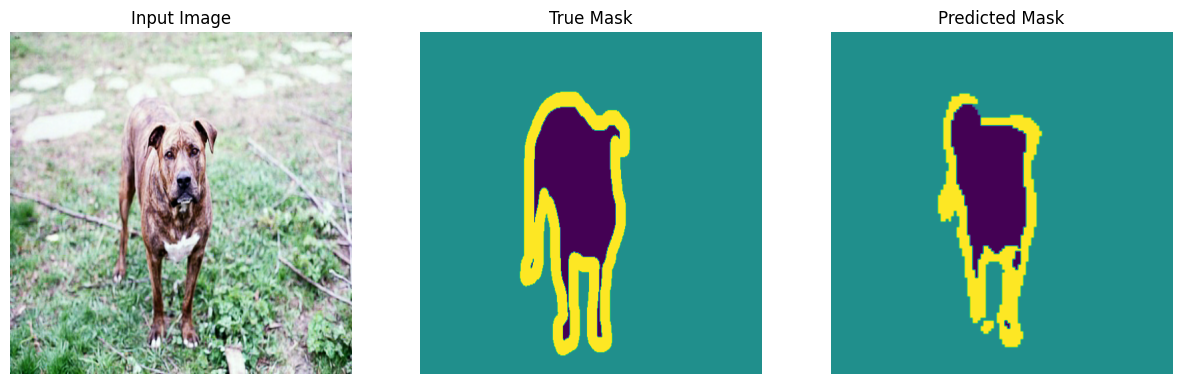

In [37]:
show_predictions(test_ds,5)

In [38]:
import gc
del input_imgs
gc.collect()

39416